#### **0. Import Libraries and define Options**

***Import Libraries***

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import scipy.stats
import warnings

warnings.filterwarnings('ignore')

***Define some hyperparameters***

---
$$
    \text{Hyperparamerters you should define}
$$
---

In [2]:
# Set initial Training samples
IDX_INIT_MODEL = 20000
# IDX_INIT_MODEL = 10000

# Optimal PC Selection Method
cv_types = ["full"]

# Optimal PC Selection Method
Opt_PC_select_method = 'eigengap'

# Significance level for setting threshold
# 99.7% inlier and 1% outlier
# alpha = 0.95 # 95%
alpha = 0.997 # 99.7%

# Define type of anomaly detection
col_interest = ['CG_1', 'CG_2', 'TT_1','TT_2'] # Caisson #1
# col_interest = ['CG_3', 'CG_4', 'TT_3','TT_4'] # Caisson #2
max_n_comp_GMM = len(col_interest) + 3 # Empirical set-up

#### **1. Load Dataset**

In [3]:
import pickle

# load
fn_load = 'J_Dataset_1101_0630_outlier_3sig'

with open(fn_load + '.pickle', 'rb') as f:
    data = pickle.load(f)

fn = data['fn']
damage_ind = data['damage_ind']
df1, df3 = data['data'][0], data['data'][1]

#### **2. Set Dataset (Train & Test)**

***Define Dataset***

In [4]:
if 0:
    col_interest = ['Time', 'CG_1', 'CG_2', 'TT_1', 'TT_2']
    df = df1[col_interest]
    Label = df1.Label.values

else:
    col_interest = ['Time', 'CG_3', 'CG_4', 'TT_3', 'TT_4']
    df = df3[col_interest]
    Label = df3.Label.values

X_all = df.values[:, 1:]

***Reduce the sequence of dataset (too many samples)***

<font color= 'red'><B>
sample should be reduced for computational issues in this tutorial. In reality, it doesn't matter becauses of online implemtation.
</font></B>

In [5]:
import pandas as pd

n_skip = 10

def reduce_sequence_by_skip(n_skip, dat):
    if isinstance(dat, pd.DataFrame):
        dat = dat.iloc[::n_skip, :]
    else:
        if dat.ndim == 1:
            dat = dat[::n_skip,]
        else:
            dat = dat[::n_skip, :]
        
    return dat

Label = reduce_sequence_by_skip(n_skip, Label)
X_all = reduce_sequence_by_skip(n_skip, X_all)
df = reduce_sequence_by_skip(n_skip, df)

IDX_INIT_MODEL = int(IDX_INIT_MODEL/n_skip)
df = df.reset_index()

***Find damage index as # index of sample***

In [6]:
damage_ind = []
for ind_label in np.unique(Label):
    if ind_label != 0:
        ind_damage = np.where(Label == ind_label)[0][0]
        damage_ind.append(ind_damage)
damage_ind

[2972]

***Plot Ground Truth (label)***

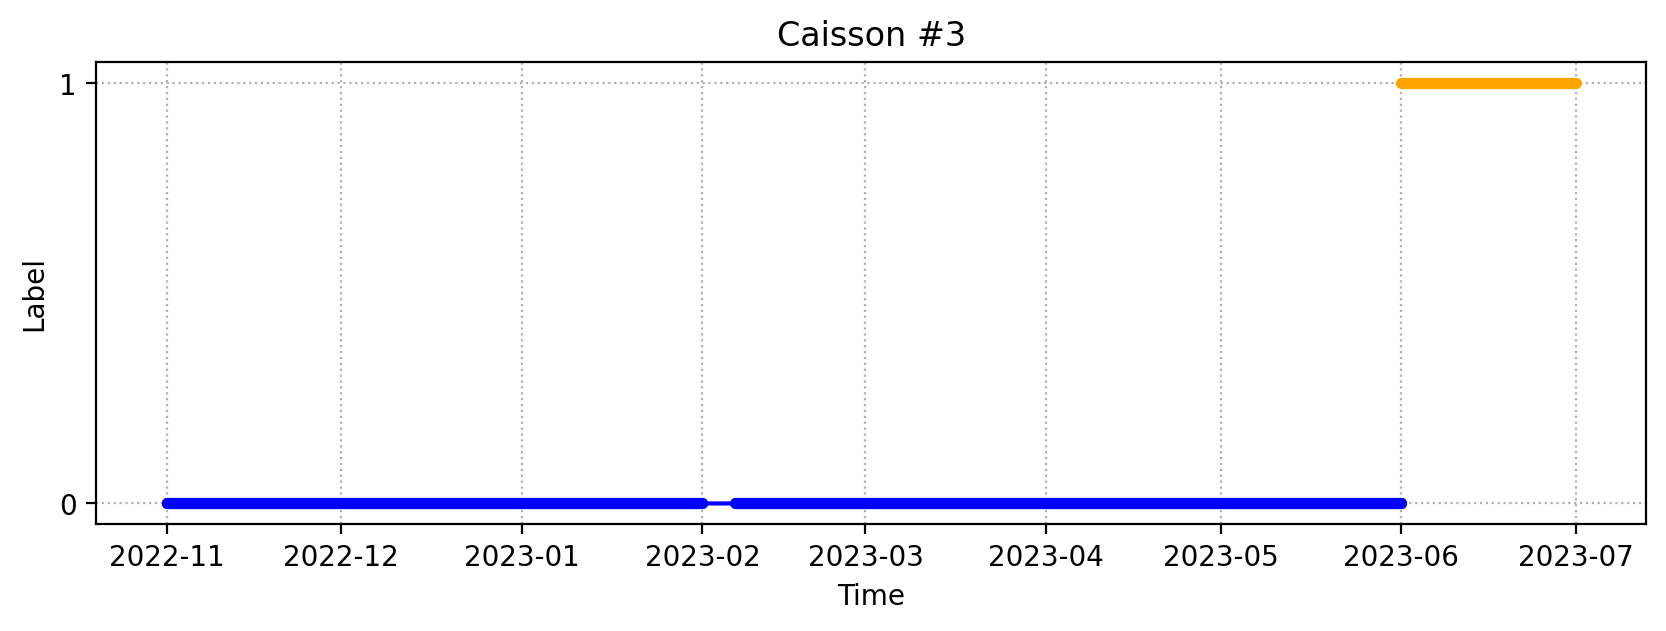

In [7]:
# Plot scatter plot (Time index vs. Label)
color_type_str = ['blue', 'orange', 'red']

plt.figure(figsize = (10, 3), dpi = 200)
for label_ind in np.unique(Label):
    indice_ = np.where(Label == label_ind)
    plt.plot(df.Time.iloc[indice_], Label[indice_], marker = '.', color = color_type_str[label_ind])
plt.xlabel('Time')
plt.ylabel('Label')
plt.gca().set_yticks([0, label_ind])
plt.grid(linestyle = ':')
if 'CG_1' in df.columns:
    struct_type = 'Caisson #1'
else:
    struct_type = 'Caisson #3'

plt.title(struct_type)
plt.show()

***Define Training and Test Dataset***

In [8]:
# Set last index for normal state
IDX_NORMAL = damage_ind[0] - 1

if IDX_INIT_MODEL > IDX_NORMAL:
    IDX_INIT_MODEL = IDX_NORMAL
    print(f'Index for Normal state should be less than index of damage {damage_ind[0]}')

# For Allocation of memory
SIZE_ALL = X_all.shape[0]

***Plot Rawdata in line plot***

In [9]:
if 0:
    color_type_str = ['blue', 'orange', 'red']

    for col_ind in range(X_all.shape[1]):
        plt.figure(figsize = (10, 3), dpi = 200)
        for label_ind in np.unique(Label):
            row_ind = np.where(Label == label_ind)
            plt.plot(df.Time.iloc[row_ind], X_all[row_ind, col_ind].reshape(-1, 1),
                    marker = '.', color = color_type_str[label_ind])
        plt.xlabel('Time')
        plt.ylabel(list(df.columns[1:])[col_ind])
        plt.grid(linestyle = ':')
        plt.title(struct_type)
        plt.show()

#### **3. Set Initial Dataset & Scaling (Standardization)**

***Set Initial Traininigset and Testset***

In [10]:
Xtrain = X_all[0:IDX_INIT_MODEL,:]
Xtest = X_all[IDX_INIT_MODEL:,:]

#### **4. Construct Baseline model using initial trainig dataset**

***Helper function for ftting PCA***

- Fitting GMM with model selection framework based on BIC

In [11]:
def fit_best_GMM(X, n_comp_min = 1, n_comp_max = 5, cv_types = ["spherical", "tied", "diag", "full"]):
    import numpy as np
    import itertools

    from scipy import linalg
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    from sklearn import mixture

    if X.shape[1] == 1:
        cv_types = 'Uni'

    lowest_bic = np.infty
    fitted_gmms, bic = [], []
    n_components_range = range(n_comp_min, n_comp_max)
    cv_types = cv_types
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            if X.shape[1] == 1:
                gmm = mixture.GaussianMixture(n_components = n_components)
            else:
                gmm = mixture.GaussianMixture(
                    n_components = n_components, covariance_type = cv_type)
            gmm.fit(X)
            fitted_gmms.append(gmm)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    return fitted_gmms, best_gmm, bic

In [12]:
def perform_PCA_given_data(X):
    '''
        - Input
            X : Normalzied training samples [N(# samples)-by-f(# features)]

        - Output
            pca: fitted PCA model
            explVar: exaplined variance for PCs
            V: principal compoent vectors
            n_comp: # retained PCs
    '''
    from sklearn.decomposition import PCA
    pca = PCA().fit(X)

    # Explained variance of each features for PCA
    expVars = pca.explained_variance_
    
    # Retained PCs
    V = pca.components_
    
    # Singular values
    S = pca.singular_values_

    return pca, expVars, V, S

In [13]:
# Compute Monitroing metrics and their thresholds
def Project_X_into_PCs(X, V, retaind_PCs):
    return np.matmul(X, V[retaind_PCs].T)

In [14]:
def run_local_PCA(Xtrain, Opt_PC_select_method):
    pca, expVars, V, S = perform_PCA_given_data(Xtrain)

    # Select optimal # of PC: n_comp
    if Opt_PC_select_method == 'eigengap':
        # Select optimal # of PCs: eigengap technique
        # % ref.1) The rotation of eigenvectors by a perturbation (1970)
        # % ref.2) Adaptive data-derived anomaly detection in the activated... (2016)
        n_comp = np.argmax(np.abs(np.diff(expVars)))
    retaind_PCs = np.arange(n_comp + 1)

    
    X_proj = Project_X_into_PCs(Xtrain, V, retaind_PCs)
    return X_proj, retaind_PCs, V, S

#### **Monitoring Statistics #1**

**Q-Statistics**
$$
    Q(X, P_{1:r}) = X(I - P_{1:r}P_{1:r}^T)X^T = \| X - \hat{X} \|^2
$$

where $\hat{X} = P_{1:r} X$
- $X$: Standardized X
- $P$: Principal component (PC) vectors
- $r$: # of retained PCs

**Threshold of Q-Statistics**

$$
    Q_{alpha} = \frac{\theta_2}{2 \theta_1}\chi_{\alpha}^2(h)
$$

where,
- $\theta_1$: sample mean
- $\theta_2$: sample variance
- $\chi_{\alpha}^2(h)$: chi-squared distribution with $h$ degree of freedom and the significance level $\alpha$
- $h = \frac{2\theta_1^2}{\theta_2}$

> Note it is based on normality assumption on Q-statistics

In [15]:
def compute_Q_statistics(X, X_proj, V, retaind_PCs):
    return np.sqrt(np.sum(
    (X - np.matmul(X_proj, V[retaind_PCs]))**2
    , axis = 1))

def compute_Threshold_Q(Q, alpha):
    from scipy.stats.distributions import chi2
    
    theta1 = np.mean(Q)
    theta2 = np.var(Q)
    h = 2 * (theta1 ** 2) / theta2
    chi_h = chi2.ppf(alpha, df=h)
    Qlimit = theta2/(2*theta1) * chi_h
    return Qlimit

#### **Monitoring Statistics #2**

**Hotelling’s T2 Statistic**

Now to calculate the T2 statistic, just transform each example.

We calculate the SVD decomposition of the covariance matrix, and with that we can use the equation below to calculate the z_score to each example in our dataset

$$
    z = \Lambda_{1:r}^{-1/2}P_{1:r}^TX, \\
    \text{ } \\
    T^2 =z^Tz
$$

where,
- X: Standardized X
- $\Lambda$:
- $P$: Principal component (PC) vectors
- $r$: # of retained PCs

**Threshold of T2-Statistics**

$$
    T_{\alpha}^{2} = \frac{m(n-1)(n+1)}{n(n-m)} F_{\alpha}(m, n - m)
$$

where,
- $n$: # of samples
- $m$: # of retained PCs
- $F_{\alpha}(m, n-m)$: F-distribution with $r$ and $(n-m)$ degrees of freedom with significance level $\alpha$

In [16]:
def compute_T2_statistics(X_proj, S, retaind_PCs):
    S_inverse = np.mat(np.diag(S[retaind_PCs])).I

    T2 = np.empty((X_proj.shape[0], ), dtype=np.float64)
    for i in range(X_proj.shape[0]):
        value = np.matmul(np.matmul(X_proj[i], S_inverse), X_proj[i])
        T2[i] = float(value)

    return T2

def compute_Threshold_T2(T2, retaind_PCs, alpha):
    Ntrain, dim = T2.shape[0], retaind_PCs.shape[0]
    t2limit = ((dim*(Ntrain-1))/ (Ntrain - dim)) * \
        scipy.stats.f.ppf(q=alpha, dfn=dim, dfd=Ntrain - dim)
    
    return t2limit

***Run PCA for initial training dataset***
- pca: PCA class instance
- expVARs: Explained variances ($=\frac{S_i}{\sum S_i}$)
- V: Principal Component Vectors
- S: Singular Values

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

- *Fit GMM with model selection framework*

In [18]:
# Automatic model selection for GMM
fitted_gmm, best_gmm, bics = fit_best_GMM(Xtrain_scaled,
                                        n_comp_min = 1, n_comp_max = max_n_comp_GMM,
                                        cv_types = cv_types)

df_gmm = []
for gmm, bic in zip(fitted_gmm, bics):
    df_gmm.append([gmm.covariance_type, gmm.n_components, bic])
df_gmm = pd.DataFrame(df_gmm, columns = ['covariance_type', 'n_component', 'bic'])
df_gmm.sort_values(by=['bic'], ignore_index = True)

print(f'[Best GMM] Cov_type:  {best_gmm.covariance_type} // # Opt. comp.: {best_gmm.n_components}')

[Best GMM] Cov_type:  full // # Opt. comp.: 6


#### **Evaluation Step (Monitoring Phase)**

In [19]:
Qthreshold, T2threshold = [], []
Qoutlier, Toutlier =[], []
Qtest, T2test = [], []

for i_xtest, xtest in enumerate(Xtest):
    # Scale xtest (new sample) using scaler of training data
    xtest_scaled = scaler.transform(xtest.reshape(1,-1)) # for new sample

    # Make predicted labels for xtest (new sample) and training data
    ytest_pred = best_gmm.predict(xtest_scaled) # new sample
    Ytrain_pred = best_gmm.predict(Xtrain_scaled) # training data

    # Find indice of training data that have same index of new sample using current GMM model (clustering result)
    ind_cluster = np.where(Ytrain_pred == ytest_pred)[0]
    Xtrain_local = Xtrain_scaled[ind_cluster] # traning samples that have same clustering label to new sample

    # Perform PCA on the traning samples that have same clustering label to new sample (Local PCA) => baseline pca
    X_proj, retaind_PCs, V, S = run_local_PCA(Xtrain_local, Opt_PC_select_method) 

    # Compute threshold
    Q_local = compute_Q_statistics(Xtrain_local, X_proj, V, retaind_PCs)
    Qlimit = compute_Threshold_Q(Q_local, alpha)

    T2_local = compute_T2_statistics(X_proj, S, retaind_PCs)
    T2limit = compute_Threshold_T2(T2_local, retaind_PCs, alpha)
    
    # Save thresholds of Q and T2
    if not Qthreshold:
        for _ in range(Xtrain_scaled.shape[0]):
            Qthreshold.append(Qlimit)
    else:
        Qthreshold.append(Qlimit)
    
    if not T2threshold:
        for _ in range(Xtrain_scaled.shape[0]):
            T2threshold.append(T2limit)
    else:
        T2threshold.append(T2limit)

    # Evaluate new sample using baseline pca and thresholds
    X_proj_new = Project_X_into_PCs(xtest_scaled, V, retaind_PCs)
    Q_new = compute_Q_statistics(xtest_scaled, X_proj_new, V, retaind_PCs)
    T2_new = compute_T2_statistics(X_proj_new, S, retaind_PCs)

    # Save Q and T2 statistics of new sample    
    if not Qtest:
        for _ in range(Xtrain_scaled.shape[0]):
            Qtest.append(Q_new)
    else:
        Qtest.append(Q_new)
    
    if not T2test:
        for _ in range(Xtrain_scaled.shape[0]):
            T2test.append(T2_new)
    else:
        T2test.append(T2_new)

    if Q_new <=Qlimit: # Inlier in Q-statistics
        if not Qtest:
            for _ in range(Xtrain_scaled.shape[0]):
                Qoutlier.append(0)
        else:
            Qoutlier.append(0)
    else: # outlier
        Qoutlier.append(1)

    if T2_new <=T2limit: # Inlier in T2-statistics
        if not Qtest:
            for _ in range(Xtrain_scaled.shape[0]):
                Toutlier.append(0)
        else:
            Toutlier.append(0)
    else: # outlier
        Toutlier.append(1)

    if Q_new <=Qlimit and T2_new <=T2limit:
        Xtrain = np.concatenate([Xtrain, xtest.reshape(1,-1)], axis = 0)

    # Update Scaler
    Xtrain_scaled = scaler.fit_transform(Xtrain)

    # Update GMM
    # Automatic model selection for GMM
    fitted_gmm, best_gmm, bics = fit_best_GMM(Xtrain_scaled,
                                            n_comp_min = 1, n_comp_max = max_n_comp_GMM,
                                            cv_types = cv_types)
    

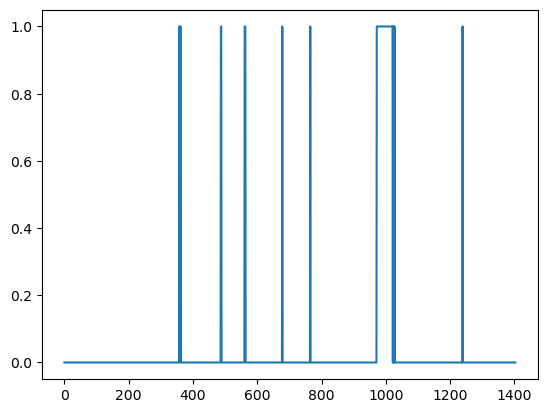

In [21]:
plt.plot(Qoutlier)
plt.show()